# Kompresja do H-macierzy

In [1]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd
import numpy as np


def truncated_svd(A, k):
    if not 0 < k < A.shape[0] + 1:
        raise ValueError("k should between 0 and A.shape[0] + 1")
    if k == A.shape[0]:
        U, s, V = svd(A)
    else:
        U, s, V = svds(A, k)
        U, s, V = U[::, ::-1], s[::-1], V[::-1]
    return U, s, V


def calculate_singular_values(matrix):
    return svd(matrix)[1]


def power_of_two(x):
    while x % 2:
        x //= 2
    return x != 1


def compress(matrix, min_value, max_rank, length):
    eps = 1e-10
    if length == 1:
        return Leaf(U=matrix, V=np.array([1])) if abs(matrix[0, 0]) > eps else Leaf(zeros=True)
    else:
        if length <= max_rank + 1:
            max_rank = length - 1
        U, s, V = truncated_svd(matrix, k=max_rank + 1)
        if np.abs(s[-1]) < min_value + eps:
            s_values = s[np.abs(s) >= min_value + eps]
            k = s_values.shape[0]
            if k == 0:
                return Leaf(zeros=True)
            return Leaf(U=U[::, :k] @ np.diag(s_values), V=V[:k])

        length //= 2
        node = InternalNode(
            left_up=compress(matrix[:length, :length], min_value, max_rank, length),
            right_up=compress(matrix[:length, length:], min_value, max_rank, length),
            left_low=compress(matrix[length:, :length], min_value, max_rank, length),
            right_low=compress(matrix[length:, length:], min_value, max_rank,  length)
        )
        return node


def compress_matrix(matrix, min_value, max_rank):
    n, m = matrix.shape
    if max_rank > n - 1:
        raise ValueError("Maximum rank should be strictly less than matrix dimension")
    if n != m:
        raise ValueError("Matrix should be square")
    if not power_of_two(n):
        raise ValueError("Matrix dimension should be power of two")

    return Tree(n, compress(matrix, abs(min_value), max_rank, n))



D:\Program Files\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from abc import ABC, abstractmethod
import numpy as np


class Tree:
    def __init__(self, length, root=None):
        self.length = length
        self.root = root

    def eval(self):
        return self.root.eval(self.length)

    def draw(self):
        def tree_depth(root):
            if isinstance(root, Leaf):
                return 0
            else:
                max_value = 1 + max(tree_depth(root.left_up), tree_depth(root.right_up), tree_depth(root.left_low),
                                    tree_depth(root.right_low))
                return max_value

        def get_draw_sizes(root):
            depth = tree_depth(root)

            draw_sizes = []

            current_size = self.length // (2 ** depth)

            for _ in range(depth + 1):
                draw_sizes.append(current_size)

                current_size = 2 * draw_sizes[-1] + 1

            return draw_sizes[::-1]

        draw_sizes = get_draw_sizes(self.root)

        image_matrix = np.ones((draw_sizes[0], draw_sizes[0]))
        self.root.draw(image_matrix, 0, 0, draw_sizes)
        return image_matrix*255


class Node(ABC):
    @abstractmethod
    def eval(self, length):
        pass

    @abstractmethod
    def draw(self, image_matrix, left, up, draw_sizes, depth):
        pass


class InternalNode(Node):
    def __init__(self, left_up, right_up, left_low, right_low):
        self.left_up = left_up
        self.right_up = right_up
        self.left_low = left_low
        self.right_low = right_low

    def eval(self, length):
        matrix = np.zeros((length, length))
        length //= 2
        matrix[:length, :length] = self.left_up.eval(length)
        matrix[:length, length:] = self.right_up.eval(length)
        matrix[length:, :length] = self.left_low.eval(length)
        matrix[length:, length:] = self.right_low.eval(length)
        return matrix

    def draw(self, im_mat, l, u, sizes, depth=0):
        k = sizes[depth] // 2

        im_mat[u: u + sizes[depth], l + k] = 0 #Siatka
        im_mat[u + k, l: l + sizes[depth]] = 0 #

        self.left_up.draw(im_mat, l, u, sizes, depth + 1)
        self.right_up.draw(im_mat, l+k+1, u, sizes, depth + 1)
        self.left_low.draw(im_mat, l, u+k+1, sizes, depth + 1)
        self.right_low.draw(im_mat, l+k+1, u+k+1, sizes, depth + 1)


class Leaf(Node):
    def __init__(self, U=None, V=None, zeros=False):
        self.U = U
        self.V = V
        self.zeros = zeros

    def eval(self, length):
        if self.zeros:
            return 0
        return self.U @ self.V

    def draw(self, image_matrix, left, up, sizes, depth=0):
        if not self.zeros:
            length = sizes[depth]

            k = self.V.shape[0]
            image_matrix[up:up+length, left:left+k] = 0
            image_matrix[up:up+k, left:left+length] = 0


# Budowa macierzy o strukturze siatki 3D

In [3]:
import random
import numpy as np


def build_matrix(k):
    n = 2 ** k
    n_2 = n ** 2

    matrix = np.zeros((n ** 3, n ** 3))

    for vertex in range(matrix.shape[0]):
        level = vertex // n_2
        rest = vertex % n_2
        row = rest // n
        col = rest % n

        if level > 0:
            top_level_neighbor = vertex - n_2
            matrix[vertex][top_level_neighbor] = random.random()

        if level < n - 1:
            bottom_level_neighbor = vertex + n_2
            matrix[vertex][bottom_level_neighbor] = random.random()

        if row > 0:
            top_neighbor = vertex - n
            matrix[vertex][top_neighbor] = random.random()

        if row < n - 1:
            bottom_neighbor = vertex + n
            matrix[vertex][bottom_neighbor] = random.random()

        if col > 0:
            left_neighbor = vertex - 1
            matrix[vertex][left_neighbor] = random.random()

        if col < n - 1:
            right_neighbor = vertex + 1
            matrix[vertex][right_neighbor] = random.random()

    return matrix

# Kompresja macierzy do H-macierzy

In [4]:
sparse_matrix = build_matrix(3)
root = compress_matrix(sparse_matrix, 0, sparse_matrix.shape[0] - 1)

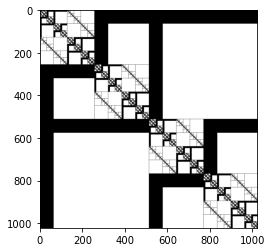

In [5]:
import matplotlib.pyplot as plt

image = root.draw()
plt.imshow(image, cmap='gray')
plt.show()

# Uruchomienie algorytmu kompresji macierzy rzadkiej

In [6]:
from scipy.sparse import csr_matrix

compressed_matrix = csr_matrix(sparse_matrix)

print('Rozmiar oryginalny:', sparse_matrix.nbytes, 'B')
print('Rozmiar po kompresji:', compressed_matrix.data.nbytes + compressed_matrix.indptr.nbytes + compressed_matrix.indices.nbytes, 'B')

Rozmiar oryginalny: 2097152 B
Rozmiar po kompresji: 34308 B


# Algorytm minimum degree

In [7]:
def get_adjacency(matrix):
    m, n = matrix.shape

    adjacency = {i : set() for i in range(m)}

    for i in range(m):
        for j in range(n):
            if i != j and matrix[i][j] > 0:
                adjacency[i].add(j)

    return adjacency

In [8]:
def minimum_degree(matrix):
    m, n = matrix.shape
    result = []
    adjacency = get_adjacency(matrix)
    
    for i in range(m):
        best_vertex = -1
        best_value = n + 1
        
        for vertex, neighbors in adjacency.items():
            if len(neighbors) < best_value:
                best_value = len(neighbors)
                best_vertex = vertex
        
        for vertex in adjacency:
            adjacency[vertex].discard(best_vertex)
        
        for neighbor in adjacency[best_vertex]:
            adjacency[neighbor] |= adjacency[best_vertex].difference({neighbor})
        
        adjacency.pop(best_vertex)
        result.append(best_vertex)
    
    return result

# Algorytm Cuthill McKee

In [9]:
from collections import deque

def cuthill_mckee(matrix):
    def bfs():
        while len(q) > 0:
            vertex = q.popleft()
            
            if visited[vertex]:
                continue
            
            visited[vertex] = True
            result.append(vertex)
            
            neighbors = sorted(list(adjacency[vertex]), key=lambda x: len(adjacency[x]))
            
            for neighbor in neighbors:
                if not visited[neighbor]:
                    q.append(neighbor)
    
    
    m, n = matrix.shape
    
    adjacency = get_adjacency(matrix)
    degrees = [(vertex, len(neighbors)) for vertex, neighbors in adjacency.items()]
    sorted_vertices = sorted(degrees, key=lambda x: x[1])
    
    for i in range(len(sorted_vertices)):
        sorted_vertices[i] = sorted_vertices[i][0]
    
    result = []
    
    q = deque()
    visited = [False for _ in range(m)]
    
    for vertex in sorted_vertices:
        if not visited[vertex]:
            q.append(vertex)
            bfs()
    
    return result

# Algorytm Reversed Cuthill McKee

In [10]:
def ceversed_cuthill_mckee(matrix):
    return cuthill_mckee(matrix)[::-1]

# Permutacja

In [11]:
def apply_permutation(matrix, permutation):
    result = matrix.copy()
    
    for i in range(len(permutation)):
        if i != permutation[i]:
            result[i, :] = matrix[permutation[i], :]
            result[:, i] = matrix[:, permutation[i]]
    
    return result

In [16]:
permutation_minimum_degree = minimum_degree(sparse_matrix)
permutation_cuthill_mckee = cuthill_mckee(sparse_matrix)
permutation_reversed_cuthill_mckee = cuthill_mckee(sparse_matrix)[::-1]

In [17]:
matrix_minimum_degree = apply_permutation(sparse_matrix, permutation_minimum_degree)
matrix_cuthill_mckee = apply_permutation(sparse_matrix, permutation_cuthill_mckee)
matrix_reversed_cuthill_mckee = apply_permutation(sparse_matrix, permutation_reversed_cuthill_mckee)

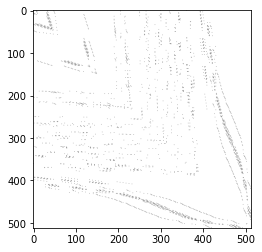

In [14]:
plt.imshow(255 * np.floor(1 - matrix_minimum_degree), cmap ="gray")
plt.show()

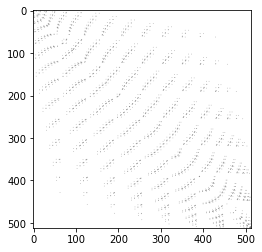

In [15]:
plt.imshow(255 * np.floor(1 - matrix_cuthill_mckee), cmap ="gray")
plt.show()

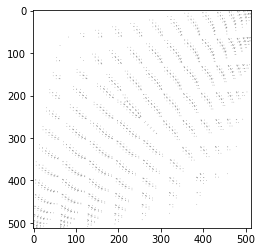

In [18]:
plt.imshow(255 * np.floor(1 - matrix_reversed_cuthill_mckee), cmap ="gray")
plt.show()